In [19]:
using POMDPs
using POMDPModels
using POMDPTools
# using Resolve

# using Random

# using GridInterpolations
# using LocalFunctionApproximation
# using LocalApproximationValueIteration

using DiscreteValueIteration
using PolicyIteration

include("testing_domains.jl")
sizee, mat = generate_test_domain("C:/repos/jukia_solvers/PolicyIteration.jl/examples/dataset-assignment2/data/maze-7-B.txt")
mdp = CustomDomain(size = sizee, grid = mat)



# solver = PolicyIterationSolver()
# mdp = SimpleGridWorld()
# mdp = SimpleGridWorld(
#     size = (50,50),
#     rewards = Dict(GWPos(x,y)=>10. for x ∈ 20:40, y ∈ 20:40)
# )
# mdp = SimpleGridWorld(
#     size = (100,100),
#     rewards = Dict(GWPos(x,y)=>10. for x ∈ 40:60, y ∈ 40:60)
# )

# grid_size = 100
# reward_grid = Dict{GWPos, Float64}()

# d = 8

# reward_grid = Dict{GWPos, Float64}();
# reward_grid[GWPos(1, 1)] = 1
# reward_grid[GWPos(d, 1)] = -1
# # reward_grid[GWPos(1, d)] = -5

# mdp = SimpleGridWorld(
# size = (d,d),
# rewards = reward_grid)


    
solver_vi = ValueIterationSolver(max_iterations=800, belres=1e-6, verbose=false) # creates the solver
solver_pi = PolicyIterationSolver(include_Q = true)
my_policy = PolicyIteration.solve(solver_pi, mdp); # runs policy iterations
# solver_approx = LocalApproximationValueIterationSolver(interp, verbose=false, max_iterations=1000, is_mdp_generative=false);
vi_policy = DiscreteValueIteration.solve(solver_vi, mdp)



Policy iteration terations: 30


ValueIterationPolicy:
 GWCoords(2, 2) -> :up
 GWCoords(2, 3) -> :right
 GWCoords(2, 4) -> :right
 GWCoords(2, 5) -> :right
 GWCoords(2, 6) -> :up
 GWCoords(3, 2) -> :up
 GWCoords(3, 3) -> :right
 GWCoords(3, 4) -> :right
 GWCoords(3, 5) -> :right
 GWCoords(3, 6) -> :up
 GWCoords(4, 2) -> :up
 GWCoords(4, 3) -> :left
 GWCoords(4, 4) -> :right
 GWCoords(4, 5) -> :up
 GWCoords(4, 6) -> :up
 GWCoords(5, 2) -> :down
 GWCoords(5, 3) -> :left
 GWCoords(5, 4) -> :down
 GWCoords(5, 5) -> :down
 …

In [15]:
# file for rendering gridworld

using Colors
using Compose
using ColorSchemes
import POMDPTools: render
import POMDPTools.ModelTools: mean_reward

function render(mdp::SimpleGridWorld, step::Union{NamedTuple,Dict}=(;); color = s->reward(mdp, s), 
    policy::Union{Policy,Nothing} = nothing, colormin::Float64 = -10.0, colormax::Float64 = 10.0,
    val_func = nothing, qmat = nothing
   )

    color = tofunc(mdp, color)

    # color_gradient = Colors.gradient(:white, :blue)
    # cgrad([:gray, :white])

    nx, ny = mdp.size
    cells = []
    for x in 1:nx, y in 1:ny
        cell = cell_ctx((x,y), mdp.size)
        

        if policy !== nothing
            a = action(policy, GWPos(x,y))
            txt = compose(context(), text(0.5, 0.5, aarrow[a], hcenter, vcenter), stroke("black"), fill("black"))
            compose!(cell, txt)
        end
        
        clr = tocolor(color(GWPos(x,y)), colormin, colormax)
        compose!(cell, rectangle(), fill(clr), stroke("gray"))

        if val_func !== nothing
            value = val_func[(y - 1) * nx + x]
            # println("value: ", value)
            # value_txt = compose(context(), text(0.5, 0.5, string(round(value, digits = 3)), hcenter, vcenter), stroke("black"), fill("black"))
            clr = value_to_color(value, minimum(val_func), maximum(val_func))
            compose!(cell, rectangle(), fill(clr), stroke("gray"))
            # compose!(cell, value_txt, rectangle(), fill(clr), stroke("gray"))

        end

        if qmat !== nothing
            q_up = round(qmat[(y - 1) * nx + x, 1], digits=2)
            q_down = round(qmat[(y - 1) * nx + x, 2], digits=2)
            q_left = round(qmat[(y - 1) * nx + x, 3], digits=2)
            q_right = round(qmat[(y - 1) * nx + x, 4], digits=2)

            txt_down = compose(context(), text(0.5, 0.8, string(q_down), hcenter, vcenter), fontsize(6pt), stroke("black"))
            txt_up = compose(context(), text(0.5, 0.2, string(q_up), hcenter, vcenter), fontsize(6pt), stroke("black"))
            txt_left = compose(context(), text(0.2, 0.5, string(q_left), hcenter, vcenter), fontsize(6pt), stroke("black"))
            txt_right = compose(context(), text(0.8, 0.5, string(q_right), hcenter, vcenter), fontsize(6pt), stroke("black"))

            compose!(cell, txt_up, txt_down, txt_left, txt_right)
        end
        
        push!(cells, cell)
    end
    grid = compose(context(), linewidth(0.5mm), cells...)
    outline = compose(context(), linewidth(1mm), rectangle(), stroke("gray"))

    agent = nothing
    next_agent = nothing

    sz = min(w,h)
    return compose(context((w-sz)/2, (h-sz)/2, sz, sz), agent, next_agent, grid, outline)
    end

function cell_ctx(xy, size)
    nx, ny = size
    x, y = xy
    return context((x-1)/nx, (ny-y)/ny, 1/nx, 1/ny)
end

tocolor(x, colormin, colormax) = x

function tocolor(r::Float64, colormin::Float64, colormax::Float64)
    frac = (r-colormin)/(colormax-colormin)
    return get(ColorSchemes.redgreensplit, frac)
end

function value_to_color(val::Float64, colormin::Float64, colormax::Float64)
    frac = (val-colormin)/(colormax-colormin)
    return get(ColorSchemes.RdBu_9, frac)
end

tofunc(m::SimpleGridWorld, f) = f
tofunc(m::SimpleGridWorld, mat::AbstractMatrix) = s->mat[s...]
tofunc(m::SimpleGridWorld, v::AbstractVector) = s->v[stateindex(m, s)]

const aarrow = Dict(:up=>'↑', :left=>'←', :down=>'↓', :right=>'→')


Dict{Symbol, Char} with 4 entries:
  :left  => '←'
  :right => '→'
  :up    => '↑'
  :down  => '↓'

In [32]:
# file for rendering testing domains

using Colors
using Compose
using ColorSchemes
import POMDPTools: render
import POMDPTools.ModelTools: mean_reward
include("testing_domains.jl")

function render_custom(mdp::CustomDomain, step::Union{NamedTuple,Dict}=(;); color = s->reward(mdp, s), 
    policy::Union{Policy,Nothing} = nothing, colormin::Float64 = -10.0, colormax::Float64 = 10.0,
    val_func = nothing, qmat = nothing
   )

    index = 1
    qindex = 1
    nx, ny = mdp.size
    cells = []
    for x in 1:nx, y in 1:ny
        cell = cell_ctx((x, y), mdp.size)

        
        if policy !== nothing && mdp.grid[x, y] != "#"
            # println(x, " ", y)
            a = action(policy, GWCoords(x,y))
            txt = compose(context(), text(0.5, 0.5, aarrow[a], hcenter, vcenter), stroke("black"), fill("black"))
            compose!(cell, txt)
        end

        if mdp.grid[x, y] == "#"
            clr = "black"
        elseif mdp.grid[x, y] == "E"
            clr = "green"
        elseif mdp.grid[x, y] == "D"
            clr = "red"
        elseif mdp.grid[x, y] == "S"
            clr = "yellow"
        else
            clr = "white"
        end 
        compose!(cell, rectangle(), fill(clr), stroke("gray"))

        if val_func !== nothing
            if mdp.grid[x, y] != "#"
                # println(x, " ", y)
                # value = val_func[(y - 1) * nx + x]
                value = val_func[index]
                index += 1
                # println("value: ", value)
                # value_txt = compose(context(), text(0.5, 0.5, string(round(value, digits = 3)), hcenter, vcenter), stroke("black"), fill("black"))
                clr = value_to_color(value, minimum(val_func), maximum(val_func))
                compose!(cell, rectangle(), fill(clr), stroke("gray"))
                # compose!(cell, value_txt, rectangle(), fill(clr), stroke("gray"))
            end
        end

        if qmat !== nothing
            if mdp.grid[x, y] != "#"

                q_up = round(qmat[qindex, 1], digits=2)
                q_down = round(qmat[qindex, 2], digits=2)
                q_left = round(qmat[qindex, 3], digits=2)
                q_right = round(qmat[qindex, 4], digits=2)
                qindex += 1

                txt_down = compose(context(), text(0.5, 0.8, string(q_down), hcenter, vcenter), fontsize(6pt), stroke("black"))
                txt_up = compose(context(), text(0.5, 0.2, string(q_up), hcenter, vcenter), fontsize(6pt), stroke("black"))
                txt_left = compose(context(), text(0.2, 0.5, string(q_left), hcenter, vcenter), fontsize(6pt), stroke("black"))
                txt_right = compose(context(), text(0.8, 0.5, string(q_right), hcenter, vcenter), fontsize(6pt), stroke("black"))

                compose!(cell, txt_up, txt_down, txt_left, txt_right)
            end
        end
        
        push!(cells, cell)
    end
    sz = min(w,h)
    grid = compose(context(), linewidth(0.5mm), cells...)
    outline = compose(context(), linewidth(1mm), rectangle(), stroke("gray"))

    agent = nothing
    next_agent = nothing

    # w,h = mdp.size
    return compose(context((h-sz)/2, (h-sz)/2, sz, sz), agent, next_agent, grid, outline)
end

function cell_ctx(xy, size)
    nx, ny = size
    y,x = xy
    # return context((x-1)/nx, (ny-y)/ny, 1/nx, 1/ny)
    return context((x-1)/nx, (y-1)/ny, 1/nx, 1/ny)
end

tocolor(x, colormin, colormax) = x

function tocolor(r::Float64, colormin::Float64, colormax::Float64)
    frac = (r-colormin)/(colormax-colormin)
    return get(ColorSchemes.redgreensplit, frac)
end

function value_to_color(val::Float64, colormin::Float64, colormax::Float64)
    frac = (val-colormin)/(colormax-colormin)
    return get(ColorSchemes.RdBu_9, frac)
end


const aarrow = Dict(:up=>'↑', :left=>'←', :down=>'↓', :right=>'→')


Dict{Symbol, Char} with 4 entries:
  :left  => '←'
  :right => '→'
  :up    => '↑'
  :down  => '↓'

[-75.66318464623487 -76.40939397940176 -75.66318464623487 -91.66754547620778; -91.18161989699716 -96.01712781209827 -75.18242054395117 -52.162884702926384; -40.8937934953552 -45.75317590184405 -79.91815836869414 -35.2880131143677; -26.223676457646363 -27.697601886399546 -31.83514490649436 -25.453351062507483; -24.10192243752217 -24.613684276201546 -24.877958911948724 -24.10192243752217; -76.97821130586244 -79.99157153311131 -77.7192591621024 -97.81291857400953; -94.81234776930397 -115.77823788162395 -79.55708393297752 -60.64736530245388; -47.95150252715895 -88.80155521110244 -91.80633327436807 -43.813959507064126; -28.304249561984367 -36.844373699947816 -38.769796375381645 -28.03997492623719; -25.006365224010356 -28.912869075134108 -27.25105514257792 -25.512404904504805; -80.96779637442894 -83.51382119767909 -83.2315914056901 -117.18895032307537; -106.78306637908963 -122.61361478188009 -88.9657120901154 -103.77828831582399; -57.31147872792622 -92.22970560831266 -112.44797770026544 -55.

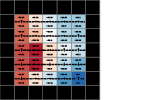

In [33]:
# include("gridworld_visualisation.jl")
# my_grid = mdp.grid
println(my_policy.qmat)
println(length(my_policy.qmat))
# println(my_policy.util)
render_custom(mdp, policy = my_policy, val_func = my_policy.util)
# render(gw)
# render(mdp, (s=[6,6],))

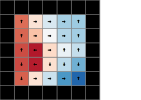

In [21]:
render_custom(mdp, policy = vi_policy, val_func = vi_policy.util)


In [ ]:
p = FunctionPolicy(s->:up)
steps = collect(stepthrough(gw, p, max_steps=100, rng=MersenneTwister(3)));

render(gw, steps[25])

In [ ]:
# Below is commented out for testing, but it can be used to explore the history

using Interact

@manipulate for i in 1:length(steps)
    render(gw, steps[i])
end

